# Import Packages

In [1]:
#pip install rainflow
import pandas as pd
import rainflow
from math import sin, cos
import matplotlib.pyplot as plt
import boto3
import botocore
import zipfile
import palmgren_miner
import numpy as np


%reload_ext autoreload
%autoreload 2

## S3 Bucket connection

In [2]:
# s3 = boto3.resource('s3')
# bucket = s3.Bucket('tum-di-lab-prod-transistor-timeseries')
# print(bucket.objects)
# BUCKET_NAME = 'tum-di-lab-prod-transistor-timeseries'  # Replace with your bucket name
# KEY = 'config33/transistor_0.zip'  # Replace with your object key (file path in the bucket)

# s3 = boto3.resource('s3')

# try:
#     s3.Bucket(BUCKET_NAME).download_file(KEY, 'local_file.zip')
#     print("File downloaded successfully.")
# except botocore.exceptions.ClientError as e:
#     if e.response['Error']['Code'] == "404":
#         print("The object does not exist.")
#     else:
#         raise

## Read Temperature values of the transistor

In [3]:
# zip_path = 'local_file.zip'

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('s3_bucket_data')

# # Read the contents of the extracted files
extracted_folder = 's3_bucket_data'
file_path = extracted_folder + '/t_trans.csv'


content = pd.read_csv(file_path, sep = ";")

# Print the content
print(content.head())

             timestamp  Temp transistor in K
0  1580871766000000000            287.048744
1  1580871767000000000            287.048744
2  1580871768000000000            287.048744
3  1580871769000000000            287.048744
4  1580871770000000000            287.048744


In [4]:
series_a = content.iloc[:,1] 
content["Temp transistor in K"]

0           287.048744
1           287.048744
2           287.048744
3           287.048744
4           287.048744
               ...    
93231723    285.695157
93231724    285.695157
93231725    285.695157
93231726    285.695157
93231727    285.695157
Name: Temp transistor in K, Length: 93231728, dtype: float64

# Linear Model

## Preprocess

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [6]:
failure_time = len(series_a)
time_data = np.arange(failure_time)
time_to_failure = np.maximum(0, failure_time - time_data)

In [7]:
timestamps = pd.to_datetime(content['timestamp'], unit='ns')
temperatures = content['Temp transistor in K']

# Rainflow analysis
# binsize is used to count them in a more compact form
cycles = rainflow.count_cycles(temperatures, binsize=5)   # Range, count

In [8]:
# Bin weight needs to be paramater
# Cycles for whole time series data
cycles

[(5, 10671631.0),
 (10, 2281453.0),
 (15, 813742.0),
 (20, 388753.0),
 (25, 151971.0),
 (30, 38224.0),
 (35, 4504.0),
 (40, 23.0),
 (45, 0.0),
 (50, 0.0),
 (55, 0.0),
 (60, 0.0),
 (65, 850.5),
 (70, 225.5),
 (75, 3.0)]

In [9]:
import numpy as np
import rainflow
from sklearn import metrics

# TODO: There is some overlap, try to find a good window and step size 
window_size = 1000  # Adjust this according to data
step_size = 100  # Adjust this according to data

rainflow_counts = []

# Create rolling window
for start in range(0, len(temperatures) - window_size + 1, step_size):
    window = temperatures[start:start+window_size]
    counts = rainflow.count_cycles(window, binsize=5)
    
    # These weights need to be adjusted or learned for Yana
    # weighted rainflow counts. It's essentially calculating a weighted sum where each count is multiplied by the corresponding bin weight (which is the bin's temperature range in this case)
    total_weighted_count = sum(count*bin_weight for bin_weight, count in counts)
    rainflow_counts.append(total_weighted_count)

rainflow_counts_array = np.array(rainflow_counts)

In [10]:
# 1. Generate 'time-to-failure' for prediction
failure_time = len(temperatures)  # assuming the end of the series is the failure time
time_to_failure = np.maximum(0, failure_time - np.arange(len(rainflow_counts_array))*step_size)

# 2. Generate the cumulative sum of the cycles in each iteration
rainflow_counts_cumsum = np.cumsum(rainflow_counts_array)

## Training and Error Analysis

In [11]:
# Do a temporal train-test split
# Change it to sampling 80-20 and 80-20 .. 80-20
split_time = int(len(rainflow_counts_cumsum) * 0.8)  # 80% for training, adjust as needed

# Add other parameters, features
X_train = rainflow_counts_cumsum[:split_time].reshape(-1, 1)
y_train = time_to_failure[:split_time]
X_test = rainflow_counts_cumsum[split_time:].reshape(-1, 1)
y_test = time_to_failure[split_time:]

# AutoRegression, check it if that is better
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Test the performance
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 9238.605056627195
Mean Squared Error: 119847427.3771476
Root Mean Squared Error: 10947.484979535144
R-squared: 0.9999958635356503


In [12]:
# Outpur of the model
y_pred[-100:-1]

array([20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.164354,
       20076.164354, 20076.164354, 20076.164354, 20076.

In [13]:
# Processes the model output to have more meaningfull result
failure_rate = 1 - y_pred/len(rainflow_counts_array)
failure_rate[-200:-1]

array([0.97845605, 0.9784563 , 0.97845654, 0.97845679, 0.97845704,
       0.97845728, 0.97845753, 0.97845778, 0.97845802, 0.97845827,
       0.97845852, 0.97845877, 0.97845901, 0.97845926, 0.97845951,
       0.97845975, 0.97846   , 0.97846025, 0.97846049, 0.97846074,
       0.97846099, 0.97846123, 0.97846148, 0.97846173, 0.97846197,
       0.97846222, 0.97846247, 0.97846271, 0.97846296, 0.97846321,
       0.97846345, 0.9784637 , 0.97846395, 0.97846419, 0.97846444,
       0.97846469, 0.97846493, 0.97846518, 0.97846543, 0.97846567,
       0.97846592, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846617,
       0.97846617, 0.97846617, 0.97846617, 0.97846617, 0.97846

## Palmgren Miner

In [18]:
palmgren_miner.palmgren_miner(content, fatigue_life = 10000000, total_lifetime = len(rainflow_counts_array))

Remaining Lifetime: -405682.63850400003
Cumulative Damage Ratio: 1.435138


## Apply the rainflow algorithm

In [15]:
x_axis = []
y_axis = []
for rng, mean, count, i_start, i_end in rainflow.extract_cycles(series_a): 
    if rng >= 1.5 and i_end <= 6600:
        print("range:", "{:.5f}".format(rng)," mean:", "{:.5f}".format(mean), " count=", "full cycle" if count == 1.0 else "half cycle", " start index:", "{:.5f}".format(i_start), " end index:", "{:.5f}".format(i_end))
        x_axis.append(int(i_start))
        y_axis.append((series_a[i_start]))
        x_axis.append(int(i_end))
        y_axis.append((series_a[i_end]))

range: 1.85080  mean: 300.75217  count= full cycle  start index: 6450.00000  end index: 6458.00000
range: 2.09808  mean: 302.32800  count= full cycle  start index: 6459.00000  end index: 6462.00000
range: 2.92751  mean: 305.63331  count= full cycle  start index: 6464.00000  end index: 6467.00000
range: 3.67638  mean: 305.92734  count= full cycle  start index: 6468.00000  end index: 6471.00000
range: 4.35469  mean: 312.06349  count= full cycle  start index: 6483.00000  end index: 6484.00000
range: 7.01114  mean: 311.95259  count= full cycle  start index: 6479.00000  end index: 6481.00000
range: 5.51893  mean: 310.47359  count= full cycle  start index: 6496.00000  end index: 6501.00000
range: 8.27594  mean: 309.43686  count= full cycle  start index: 6503.00000  end index: 6507.00000
range: 2.49972  mean: 312.68657  count= full cycle  start index: 6509.00000  end index: 6511.00000
range: 2.99880  mean: 313.33983  count= full cycle  start index: 6512.00000  end index: 6513.00000
range: 4.3

## Indicate the T_{i} and T_{e} in a specific range

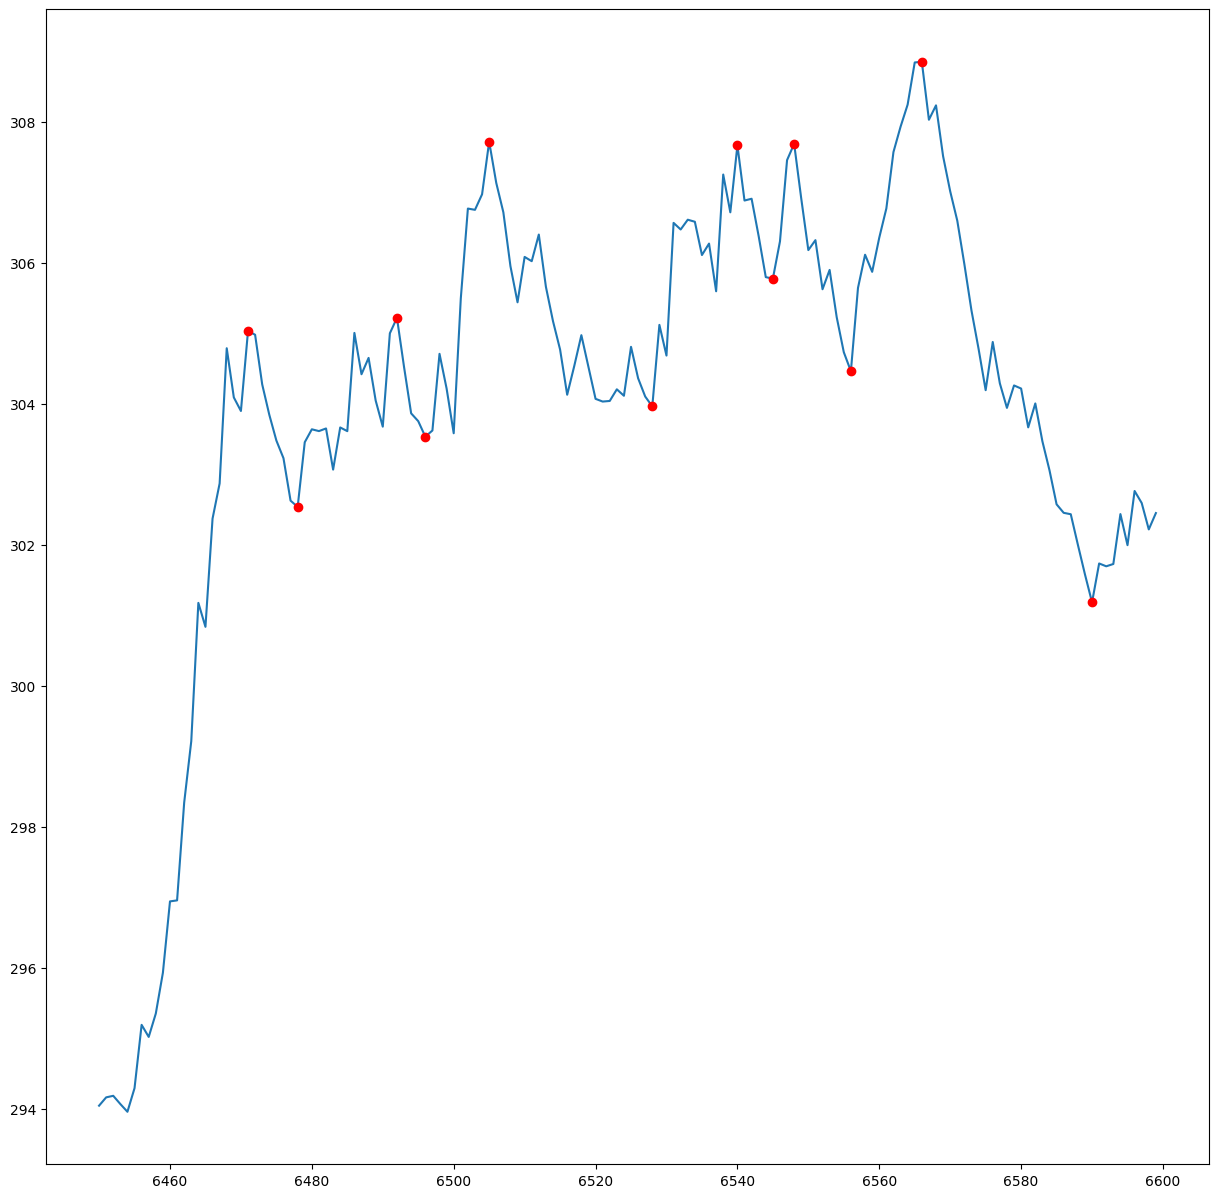

In [7]:
rainflow.count_cycles(series_a, binsize=0.5)
series_a[6450:6600].plot(figsize=(15, 15))
plt.plot(x_axis, y_axis, 'ro')
plt.show()


## Check data coming from S3

In [8]:
pd.read_csv("transistor_0/bfr.csv", nrows=5)

,timestamp;Base Failure Rate
0,1580871766000000000;0.018493972072519457
1,1580871767000000000;0.018493972072519457
2,1580871768000000000;0.018493972072519457
3,1580871769000000000;0.018493972072519457
4,1580871770000000000;0.018493972072519457


In [9]:
pd.read_csv("transistor_0/damage.csv", nrows=5)

,timestamp;Accumulated Damage
0,1580871766000000000;0.0
1,1580871767000000000;0.0
2,1580871768000000000;0.0
3,1580871769000000000;0.0
4,1580871770000000000;0.0


In [10]:
pd.read_csv("transistor_0/power.csv", nrows=5)

,timestamp;Power Consumption in W
0,1580871766000000000;0.0
1,1580871767000000000;0.0
2,1580871768000000000;0.0
3,1580871769000000000;0.0
4,1580871770000000000;0.0


In [11]:
pd.read_csv("transistor_0/risk_of_failure.csv", nrows=5)

,timestamp;Risk of Failure per Step
0,1580871766000000000;5.810831815722395e-10
1,1580871767000000000;5.810831815722395e-10
2,1580871768000000000;5.810831815722395e-10
3,1580871769000000000;5.810831815722395e-10
4,1580871770000000000;5.810831815722395e-10


In [12]:
pd.read_csv("transistor_0/t_cool.csv", nrows=5)

,timestamp;Temp cooler in K
0,1580871766000000000;287.0487435328662
1,1580871767000000000;287.0487435328662
2,1580871768000000000;287.0487435328662
3,1580871769000000000;287.0487435328662
4,1580871770000000000;287.0487435328662


In [13]:
pd.read_csv("transistor_0/t_trans.csv", nrows=5)

,timestamp;Temp transistor in K
0,1580871766000000000;287.0487435328662
1,1580871767000000000;287.0487435328662
2,1580871768000000000;287.0487435328662
3,1580871769000000000;287.0487435328662
4,1580871770000000000;287.0487435328662
